In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import random
import pandas as pd
import scipy.stats as stats

%precision 2

'%.2f'

## Coding: Feb 7th-March 14th

Create a function that incorporates all of the previous functions you made into one big one. Basically creates a large function that you input a few arrays and it generates a power spectra box.

In [2]:
#Make a function to shift, transform, and shift back
def cosmo_transform(input_box):
    #Shifting the zero frequency component to the center
    shift_1 = np.fft.fftshift(input_box)
    
    #Fourier transform after the shift
    #Need to fourier transform here, shift does not transform alone
    transformed_box = np.fft.fftn(shift_1)
    
    #Shifting the zero-frequency component back to its assumed numpy original position
    shift_2 = np.fft.ifftshift(transformed_box)
    
    return shift_2


#Creating a function to generate the k_x frequency array
def kx_frequency_array(one_D_array):
    #Fourier transform to frequency space
    #Need to fourier transform here, shift does not transform alone
    #1D array containing the wavevectors 
    #By multiplying by the total # of pixels, we convert them to pixel freq.
    kfreq = np.fft.fftfreq(one_D_array)*2*np.pi
    
    #Shifting back to its assumed numpy position
    k_x = np.fft.fftshift(kfreq)
    
    return k_x


#Creating a function to generate the k_y frequency array
def ky_frequency_array(one_D_array):
    #Fourier transform to frequency space
    #Need to fourier transform here, shift does not transform alone
    #1D array containing the wavevectors 
    #By multiplying by the total # of pixels, we convert them to pixel freq.
    kfreq = np.fft.fftfreq(one_D_array)*2*np.pi
    
    #Shifting back to its assumed numpy position
    k_y = np.fft.fftshift(kfreq)
    
    return k_y

#Function to generate start and end binning arrays
def create_bins(max_bin_value, num_bins):
    bin_size = max_bin_value / num_bins
    bin_starts = [bin_size * i for i in range(num_bins)]
    bin_ends = [bin_size * (i+1) for i in range(num_bins)]
    return bin_starts, bin_ends


#Finding the element positions given our k parameters
def find_element_positions(input_k, start, end):
    
    positions = []
    #Iterating through each element in the start and end arrays
    for k in range(len(start)):
        sub_positions = []
        #Iterating through first dimension of input_k
        for i in range(len(input_k)):
            #Iterating through second dimension of input_k
            for j in range(len(input_k[0])):
                #For elements within our inputted desired range
                if start[k] <= input_k[i][j] <= end[k]:
                    sub_positions.append((i, j))
        positions.append(sub_positions)
    
    #Will return tuples that given the locations of the elements in the given range
    return positions


#Find corresponding [i,j] positions in fourier transform array 
#Should be same dimensions as k array
def get_corresponding_values(input_k, fourier_array, start, end):
    #Calling function that returns position tuples
    positions = find_element_positions(input_k, start, end)
    
    #Empty list to store the values
    values = []
    
    #Iterate through rows in the positions array
    for pos_row in positions:
        #Initialize an empty list to store each row's values
        row_values = []
        #Iterate through pair of indices in the row
        for i, j in pos_row:
            #Index into fourier array and store value
            row_values.append(fourier_array[i][j])
            
        #Append values for this row into overall values list
        values.append(row_values)
    
    return values


#Finding averages of the values at each position
def avg_corresponding_values(input_k, fourier_array, start, end):
    
    #Get our corresponding values 2D array
    values = get_corresponding_values(input_k, fourier_array, start, end)
        
    #Creating empty avg_values array
    avg_values = []
    #Separating out ranges
    for row in values:
        row_sum = 0
        #For each value in the row
        for i in row:
            row_sum += i
            #Taking the average value for the row
            avg = row_sum/len(row)
            
        avg_values.append(avg)
    
    return avg_values
    
    
#Creating the power spectra plot
def power_spectra_plot(input_k, fourier_array, start, end, sigma):
    
    #Getting the average fourier value for the chosen k range
    avg_values = avg_corresponding_values(input_k, fourier_array, start, end)
    print(avg_values)
    #List of integers from our chosen range values
    #Will be the labels for the x-axis
    range_values = list(range(len(start)))
    
    F1 = plt.figure(figsize = (8,8))
    plt.style.use("fast")
    hfont = {'fontname':'Times New Roman'}
    plt.scatter(range_values, avg_values)
    
    #Labels
    plt.xlabel(r"k [$\mathregular{Mpc^{-1}}$]", size=25, **hfont) 
    plt.ylabel(r"$\mathregular{P(k) [mK^2]}$", size = 25, **hfont) 
    plt.suptitle("2D Toy Box - Large Sample", size = 30, **hfont)
    
    #Tick Parameters
    plt.tick_params(bottom=True, top=True, left=True, right=True, which='major', 
                    direction = "in", labelsize=20, width=1.3, color='black')
    plt.tick_params(top= True, right = True, axis='both', which='minor', direction='in', 
                    labelsize = 20, length=5, width=1.3)
    plt.yticks(fontname = "Times New Roman") 
    plt.xticks(fontname = "Times New Roman")
    
    #Remaining Plot Specifications
    plt.errorbar(range_values, avg_values, yerr=sigma, fmt='o', color = "black")
    plt.tight_layout()
    plt.show()
    
    F1.savefig("2D Toy Box - Large Sample", format="png", dpi=1200)


In [3]:
def generate_pk_2D (npix, num_bins, sigma):
    
    #Creating an array with npix dimensions
    toy_box = np.random.normal(size = (npix, npix))
    
    #Fourier transforming box (shifts included)
    k_box = cosmo_transform(toy_box)
    
    #Squaring values to find amplitude array
    amplitude = (np.abs(k_box))**2
    
    #Dividing by original volume of box
    Area = npix*npix
    
    #Getting the power spectra
    P_k = (amplitude/Area)
    
    #Creating frequency arrays
    #THIS IS THE K_X ARRAY
    k_x = kx_frequency_array(npix)
    #THIS IS THE K_Y ARRAY
    k_y = ky_frequency_array(npix)
    #Creating an array matching our toy box array
    kfreq2D = np.meshgrid(k_x, k_y)
    
    #Normalisation factor
    #Finding distance between pixels
    k_values = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    
    #Finding the maximum value of the k array
    max_k = np.max(k_values)
    
    #Defining the starting and ending arrays
    start, end = create_bins(max_k, num_bins)
    
    #Finding the element positions of the k-array using our given
    #k value ranges
    rings = find_element_positions(k_values, start, end)
    
    #Getting the corresponding fourier array values given positions
    co_values = get_corresponding_values(k_values, P_k, start, end)
    
    #Finding the average of all of these values at each index of 2D array
    averages = avg_corresponding_values(k_values, P_k, start, end)
   
    #Creating the power_spectra plot
    #Averages of all the values in the array are found in the power_spectra function
    power_spectra_plot(k_values, P_k, start, end, sigma)
    
    return power_spectra_plot

[0.0046537359853086975, 0.8139664385079513, 0.7351074594837113, 0.9907667641535746, 1.574833070172889, 0.8381503260380779, 0.47471652866181246, 0.8838220802879441, 0.7305349794142385, 0.7241908609942721, 1.0040454518471669, 0.951406266370612]


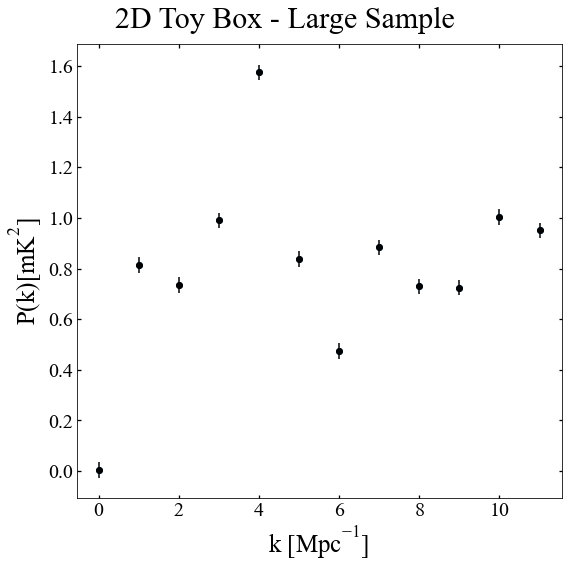

<function __main__.power_spectra_plot(input_k, fourier_array, start, end, sigma)>

In [4]:
generate_pk_2D(12, 12, 0.03)